# Deconvolute slides with Tangram

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import tangram as tg
import gc

import muon as mu

import warnings
warnings.filterwarnings('ignore')

/home/dbdimitrov/miniconda3/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
groupby = 'TaxonomyRank4'
subgroupby = 'ClusterName'
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085

In [3]:
path = os.path.join('..','..', 'data', 'sma')

In [4]:
# slide names and x, y offsets
slides = pd.read_csv(os.path.join(path, "sma_meta.csv"), index_col=0).index

Load Single-cell Reference data

In [5]:
adata = sc.read_h5ad(os.path.join(path, "l5_all.h5ad"))
adata = adata[~adata.obs.index.duplicated()] # remove duplicated index

In [6]:
# sub annotations of interest
annotations = ["MSN1", "MSN2", "MSN3", "MSN4", "MSN5", "MSN6", "OBDOP1", "OBDOP2", "MBDOP1", "MBDOP2"]

In [7]:
# for groupby, replace with ClusterName, whenever the observation is in annotations (as in Vicari et al.,)
adata.obs[groupby] = adata.obs[groupby].astype(str)
adata.obs.loc[adata.obs[subgroupby].isin(annotations), groupby] = adata.obs.loc[adata.obs[subgroupby].isin(annotations), subgroupby]

In [8]:
adata.obs = adata.obs[[groupby]]

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

Obtain Cell type markers

In [10]:
sc.tl.rank_genes_groups(adata, groupby=groupby, use_raw=False)
markers_df = pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1786

Deconvolute & Save to MuData

A1


INFO:root:1698 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14946 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1698 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.452, KL reg: 0.078
Score: 0.576, KL reg: 0.001
Score: 0.577, KL reg: 0.001
Score: 0.578, KL reg: 0.001
Score: 0.578, KL reg: 0.001
Score: 0.578, KL reg: 0.001
Score: 0.578, KL reg: 0.001
Score: 0.578, KL reg: 0.001
Score: 0.578, KL reg: 0.001
Score: 0.578, KL reg: 0.001


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


B1


INFO:root:1702 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:15112 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1702 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.443, KL reg: 0.080
Score: 0.571, KL reg: 0.001
Score: 0.572, KL reg: 0.001
Score: 0.572, KL reg: 0.001
Score: 0.572, KL reg: 0.001
Score: 0.572, KL reg: 0.001
Score: 0.572, KL reg: 0.001
Score: 0.572, KL reg: 0.001
Score: 0.572, KL reg: 0.001
Score: 0.572, KL reg: 0.001


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


C1


INFO:root:1701 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:15286 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1701 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.461, KL reg: 0.073
Score: 0.586, KL reg: 0.001
Score: 0.587, KL reg: 0.001
Score: 0.588, KL reg: 0.001
Score: 0.588, KL reg: 0.001
Score: 0.588, KL reg: 0.001
Score: 0.588, KL reg: 0.001
Score: 0.588, KL reg: 0.001
Score: 0.588, KL reg: 0.001
Score: 0.588, KL reg: 0.001


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


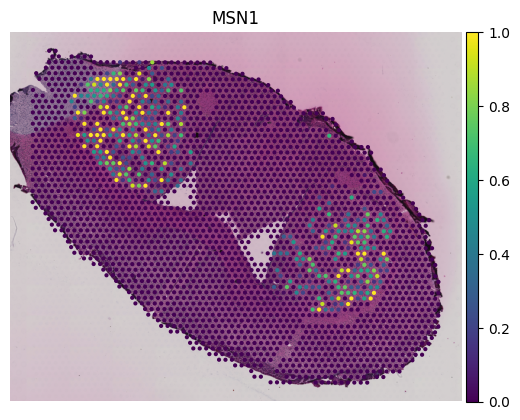

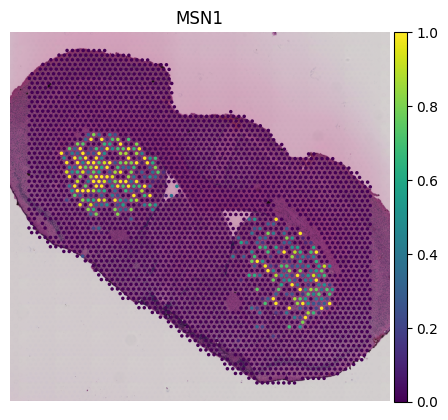

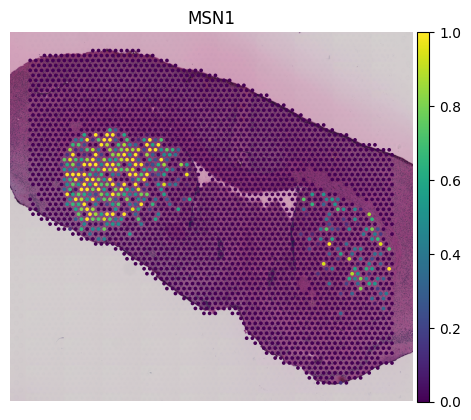

In [11]:
for slide in slides:
    print(slide)
    slide_path = os.path.join(path, exp, f"{exp}_{slide}", "output_data")
    mdata = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
    spdata = mdata.mod['rna'].copy()
    
    tg.pp_adatas(adata, spdata, genes=markers)
    
    ad_map = tg.map_cells_to_space(
                adata, 
                spdata,         
                mode='clusters',
                cluster_label=groupby)
    
    tg.project_cell_annotations(ad_map, spdata, annotation=groupby)
    tg.plot_cell_annotation_sc(spdata, ['MSN1'], perc=0.02)
        
    deconv = spdata.obsm['tangram_ct_pred']

    deconv = sc.AnnData(X = deconv.values,
                        obs = spdata.obs,
                        var = pd.DataFrame(index=deconv.columns),
                        uns = spdata.uns,
                        obsm = spdata.obsm,
                        )
    mdata.mod['deconv'] = deconv
    
    mdata.write_h5mu(os.path.join(slide_path, "sma.h5mu"))